In [1]:
## extention of "https://docs.astropy.org/en/stable/coordinates/frames.html"
import numpy as np
import pylab as pl
from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import ITRS
from astropy.coordinates import EarthLocation, AltAz

In [2]:
## create satellite object

s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
satellite = Satrec.twoline2rv(s, t)
world = np.load('world.npy')

In [3]:
# simple map plotting routine

def plot_world_map():
    pl.figure(figsize=(12, 6))
    pl.fill(world[:,0], world[:,1], color='k', alpha=.1)
    pl.xlim(-180, 180)
    pl.ylim(-90, 90)
    pl.xticks(np.arange(-180, 181, 60))
    pl.yticks(np.arange(-90, 91, 30))
    pl.axis('equal')

In [4]:
# grab a single TEME position and velocity

t = Time(2458827.362605, format='jd')
error_code, teme_p, teme_v = satellite.sgp4(t.jd1, t.jd2)  # in km and km/s
if error_code != 0:
    raise RuntimeError(SGP4_ERRORS[error_code])

teme_p = CartesianRepresentation(teme_p*u.km)
teme_v = CartesianDifferential(teme_v*u.km/u.s)
teme = TEME(teme_p.with_differentials(teme_v), obstime=t)

In [5]:
### convert to geodetic

itrs_geo = teme.transform_to(ITRS(obstime=t))
location = itrs_geo.earth_location
location.geodetic  

siding_spring = EarthLocation.of_site('aao')  
topo_itrs_repr = itrs_geo.cartesian.without_differentials() - siding_spring.get_itrs(t).cartesian
itrs_topo = ITRS(topo_itrs_repr, obstime = t, location=siding_spring)
aa = itrs_topo.transform_to(AltAz(obstime=t, location=siding_spring))
print(aa.alt, aa.az) 

10d56m52.78793904s 59d17m16.92201911s


In [6]:
times = [Time(2458827.362605 + i/86400., format='jd') for i in range(86400)]
jd = np.array([(t.jd1, t.jd2) for t in times])

In [7]:
ephem = np.array([satellite.sgp4(t.jd1, t.jd2)[1:] for t in times]) 

In [8]:
ephem.shape

(86400, 2, 3)

In [9]:
ephem = ephem.reshape((-1, 6))
ephem.shape

(86400, 6)

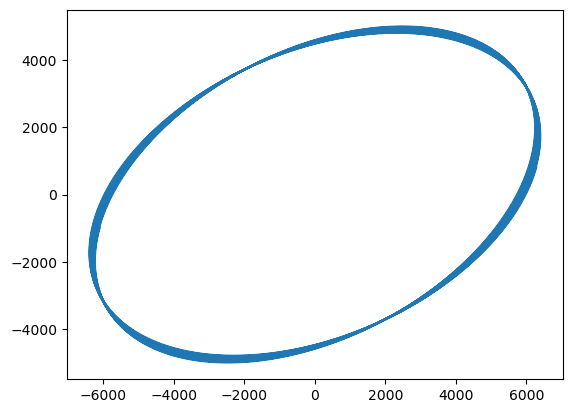

In [10]:
pl.figure()
pl.plot(ephem[:,0], ephem[:,1])

In [11]:
sidereal_day = 23 * 3600 + 56 * 60 + 4.09
DEG = np.pi / 180
omega = 2 * np.pi/ sidereal_day
theta = omega * np.arange(86400)
theta / DEG

array([0.00000000e+00, 4.17807465e-03, 8.35614930e-03, ...,
       3.60973115e+02, 3.60977293e+02, 3.60981472e+02])

In [12]:
cost = np.cos(theta)
sint = np.sin(theta)
R = np.zeros((86400, 3, 3))
R[:,2,2] = 1
R[:,0,0] = cost
R[:,1,1] = cost
R[:,0,1] = -sint
R[:,1,0] =  sint


In [13]:
ephem_ecf = np.array([np.hstack([r @ e[:3], r @ e[3:]]) for r, e in zip(R, ephem)])
x = ephem_ecf[:,0]
y = ephem_ecf[:,1]
z = ephem_ecf[:,2]
sat_lon = np.arctan2(y, x)
sat_lat = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))

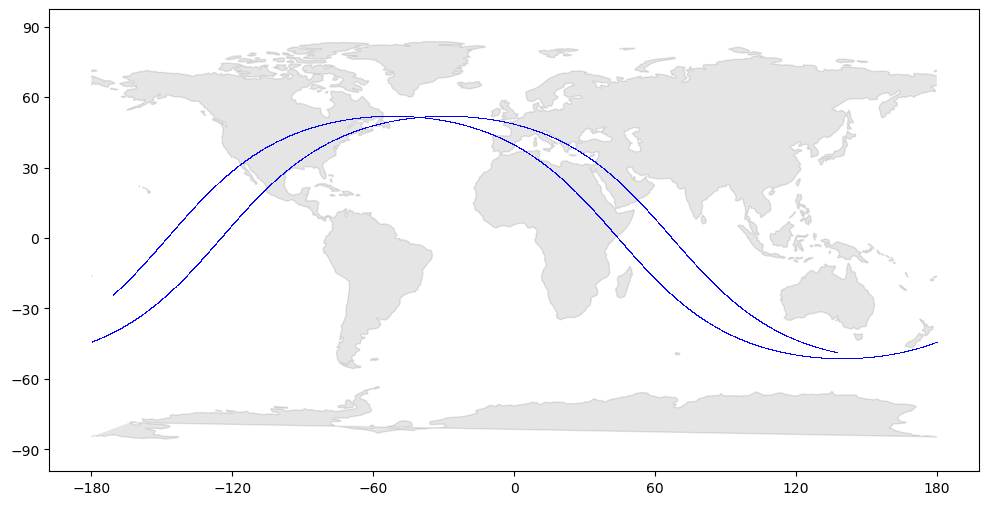

In [14]:
plot_world_map()
pl.plot(sat_lon[:10000] / DEG, sat_lat[:10000] / DEG, 'b,')


(-7015.950699999999, 7015.950699999999, -7015.950699999999, 7015.950699999999)

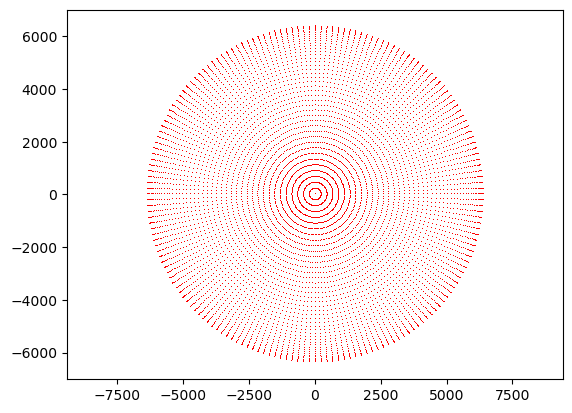

In [15]:
_lat = np.linspace(-90, 90, 91) * DEG
_lon = np.linspace(-180, 180, 181) * DEG
EARTH_RADIUS = 6378.137

lat, lon = np.meshgrid(_lat, _lon); lat = lat.ravel(); lon = lon.ravel()
gx = EARTH_RADIUS * np.sin(lat) * np.cos(lon)
gy = EARTH_RADIUS * np.sin(lat) * np.sin(lon)
gz = EARTH_RADIUS * np.cos(lat)
g_ecf = np.column_stack([gx, gy, gz])
up = g_ecf / EARTH_RADIUS
pl.plot(gx, gy, 'r,')
pl.axis('equal')


2131.0


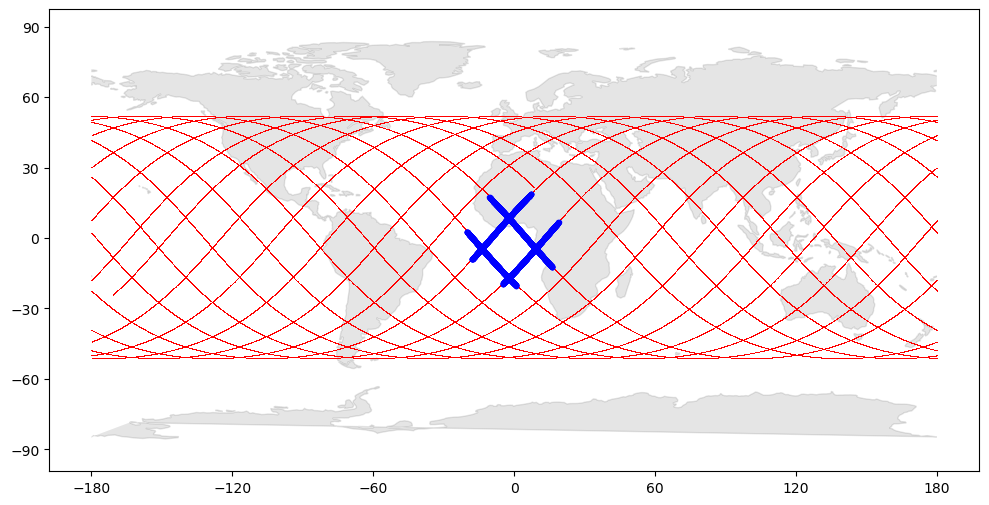

In [16]:
def visibility(ephem_ecf, g):
    g = np.array(g)
    doa = (g - ephem_ecf[:,:3])
    inview = -doa @ g > 0
    return inview
def coverage(ephem_ecf, g, dt):
    inview = visibility(ephem_ecf, g)
    return sum(inview) * dt
    
g = np.array([EARTH_RADIUS, 0, 0])
v = visibility(ephem_ecf, g)
print(coverage(ephem_ecf, g, 1.))
plot_world_map()
j = pl.plot(sat_lon / DEG, sat_lat / DEG, 'r,')
j = pl.plot(sat_lon[v] / DEG, sat_lat[v] / DEG, 'b.')
j = pl.axis('equal')
    

In [17]:
## compute coverage for a few points to save time
cov = np.array([coverage(ephem_ecf, g, 1.) for g in g_ecf[::100]])

In [18]:
cov.shape

(165,)